# Imports

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import jax
import networkx as nx
import jax.numpy as jnp
from jax import random
from jax.lax import scan

# SNN Architecture Null Model - Input & Main

This code generates a Networkx Graph that has the structure we want for the SNN. It generates a bunch of randomly connected neurons of which 80% are excitatory and 20% inhibitory. Further the sparsity of the network can be controlled. Additionally, an input layer of n neurons is added which is randomly connected to a subset of the main network with excitatory connections. 

# Sanity test: 3 Neurons in a chain, no learning

This code simulates only 3 neurons, which are connected in a chain + no self-connections. Only the first neuron in the chain receives external input. The activity looks as expected. Play around with the connectivity matrix and the value of I_ext in the network_update function to see how the network behaves. Notice currently weights do not change.

# Network of neurons with input and STDP with connectivity generated from networkx graph

Same code as for the 3 neuron simulation, but now the connectivity matrix is initialized from the networkx graph with input and main neurons. Initial weights are true to Dale's principle, but it needs to be fixed that neurons do not switch from excitatory to inhibtiory over time with STDP.

## Generate Network Graph

This is a slightly improved version of the graph above which ensures that all neurons have outgoing connections.

In [5]:

def generate_neural_network(num_neurons, excitatory_ratio=0.8, connection_prob=0.1):
    """
    Generates a neural network with excitatory and inhibitory neurons.

    Args:
        num_neurons (int): Total number of neurons.
        excitatory_ratio (float): Proportion of excitatory neurons (default: 0.8, for 4:1 ratio).
        connection_prob (float): Probability of connection between any two neurons.
    
    Returns:
        G (nx.DiGraph): Directed graph representing the network.
    """
    # Number of excitatory and inhibitory neurons
    num_excitatory = int(num_neurons * excitatory_ratio)
    num_inhibitory = num_neurons - num_excitatory

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes with attributes (excitatory or inhibitory)
    for i in range(num_neurons):
        if i < num_excitatory:
            G.add_node(i, type=1)
        else:
            G.add_node(i, type=-1)

    # Add edges with weights, respecting Dale's principle
    for i in range(num_neurons):
        for j in range(num_neurons):
            if i != j and np.random.rand() < connection_prob:
                if G.nodes[i]["type"] == 1:
                    weight = np.random.normal(5.0, 1.0)  # Positive weight for excitatory
                else:
                    weight = np.random.normal(-5.0, 1.0)  # Negative weight for inhibitory
                G.add_edge(i, j, weight=weight)
    
    # Ensure each excitatory or inhibitory neuron has at least one outgoing connection
    for i in range(num_neurons):
        if len(list(G.out_edges(i))) == 0:  # No outgoing connections
            # Find a random target neuron
            target = np.random.choice(num_neurons)
            while target == i:  # Ensure no self-loop
                target = np.random.choice(num_neurons)
            if G.nodes[i]["type"] == 1:
                weight = np.random.normal(5.0, 1.0)  # Positive weight for excitatory
            else:
                weight = np.random.normal(-5.0, 1.0)  # Negative weight for inhibitory
            G.add_edge(i, target, weight=weight)
    
    return G

def add_input_layer(G, num_input_nodes=10, subset_size=30, input_prob=0.5):
    """
    Adds an input layer to the neural network.

    Args:
        G (nx.DiGraph): Existing neural network graph.
        num_input_nodes (int): Number of input nodes to add.
        subset_size (int): Size of the subset of existing neurons to connect to.
        input_prob (float): Probability of connection from input nodes to subset neurons.

    Returns:
        G (nx.DiGraph): Updated graph with input layer.
    """
    num_existing_neurons = len(G.nodes)
    input_layer_start = num_existing_neurons

    # Add input nodes
    for i in range(num_input_nodes):
        G.add_node(input_layer_start + i, type=0)

    # Randomly select a subset of existing neurons
    subset_neurons = np.random.choice(num_existing_neurons, subset_size, replace=False)

    # Add edges from input nodes to subset neurons with the given probability
    for input_node in range(input_layer_start, input_layer_start + num_input_nodes):
        for target_neuron in subset_neurons:
            if np.random.rand() < input_prob:
                weight = np.random.uniform(5, 10)  # Adjust weight range if needed
                G.add_edge(input_node, target_neuron, weight=weight)
    
    return G


def plot_network(G):
    """
    Plots the network, color-coding excitatory and inhibitory neurons.

    Args:
        G (nx.DiGraph): Directed graph representing the network.
    """
    pos = nx.random_layout(G)  # Layout for visualization
    excitatory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 1]
    inhibitory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == -1]
    input_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 0]
    
    num_input_nodes = len(input_nodes)
    for i, node in enumerate(input_nodes):
        pos[node] = (-0.1, i / (num_input_nodes - 1) if num_input_nodes > 1 else 0.5)

    plt.figure(figsize=(15,10))
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=excitatory_nodes, node_color="red", label="Excitatory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=inhibitory_nodes, node_color="blue", label="Inhibitory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_color="green", label="Input Nodes", alpha=0.7, node_size=50)

    # Draw edges
    weights = nx.get_edge_attributes(G, "weight")
    excitatory_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == 1]
    inhibitory_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == -1]
    input_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == 0]

    nx.draw_networkx_edges(G, pos, edgelist=excitatory_edges, edge_color="red", arrowstyle="->", arrowsize=10, alpha=0.7, label="Excitatory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=inhibitory_edges, edge_color="blue", arrowstyle="->", arrowsize=10, alpha=0.7, label="Inhibitory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=input_edges, edge_color="green", arrowstyle="->", arrowsize=10, alpha=0.7, label="Input Connections")


    # Add legend
    plt.legend()
    plt.title("Neural Network with Excitatory and Inhibitory Neurons")
    plt.axis("off")
    plt.show()

# Parameters
num_neurons = 1000  # Total number of neurons
excitatory_ratio = 0.8  # 4:1 ratio (80% excitatory)
connection_prob = 0.1  # Connection probability

# Generate and plot network
G = generate_neural_network(num_neurons, excitatory_ratio, connection_prob)
G = add_input_layer(G, num_input_nodes=784, subset_size=400, input_prob=0.5)
# plot_network(G)

## Run simulation with 100 neurons

In [13]:
import numpy as np
from torchvision import datasets, transforms
import jax.numpy as jnp

# Define transformations (convert to tensor, normalize)
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=False, transform=transform)

# Convert data to NumPy arrays
train_images = np.array([np.array(img[0]).squeeze() for img in train_dataset])
train_labels = np.array([label for _, label in train_dataset])

test_images = np.array([np.array(img[0]).squeeze() for img in test_dataset])
test_labels = np.array([label for _, label in test_dataset])

# Convert to JAX arrays
train_images = jnp.array(train_images, dtype=jnp.float32)
train_labels = jnp.array(train_labels, dtype=jnp.int32)

test_images = jnp.array(test_images, dtype=jnp.float32)
test_labels = jnp.array(test_labels, dtype=jnp.int32)

train_images = train_images * 255.0
test_images = test_images *255.0

# Normalize images
#train_images /= 255.0
#test_images /= 255.0

# Outputs: train_images, train_labels, test_images, test_labels

In [11]:

import tensorflow_datasets as tfds

# Load the MNIST dataset
ds_builder = tfds.builder('mnist')
ds_builder.download_and_prepare()
train_ds = tfds.as_numpy(
    ds_builder.as_dataset(split="train", batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split="test", batch_size=-1))

# Normalize data
train_images, train_labels = train_ds['image'], train_ds['label']
test_images, test_labels = test_ds['image'], test_ds['label']

train_images = jnp.float32(train_images)*255.0
# train_images = jnp.float32(train_images) / 255.0
test_images = jnp.float32(test_images)*255.0
# test_images = jnp.float32(test_images) / 255.0

ModuleNotFoundError: No module named 'tensorflow_datasets'

Only the 10 input neurons receive external stimulation. This can also be extended to 10x as many or more neurons and works too, but some things need to be changed in the code itself too (which subset receives input).

In [19]:
train_labels[0]

Array(5, dtype=int32)

C:\Users\hanna\AppData\Local\Temp\ipykernel_2428\781245933.py:155: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix_sparse = nx.adjacency_matrix(G)


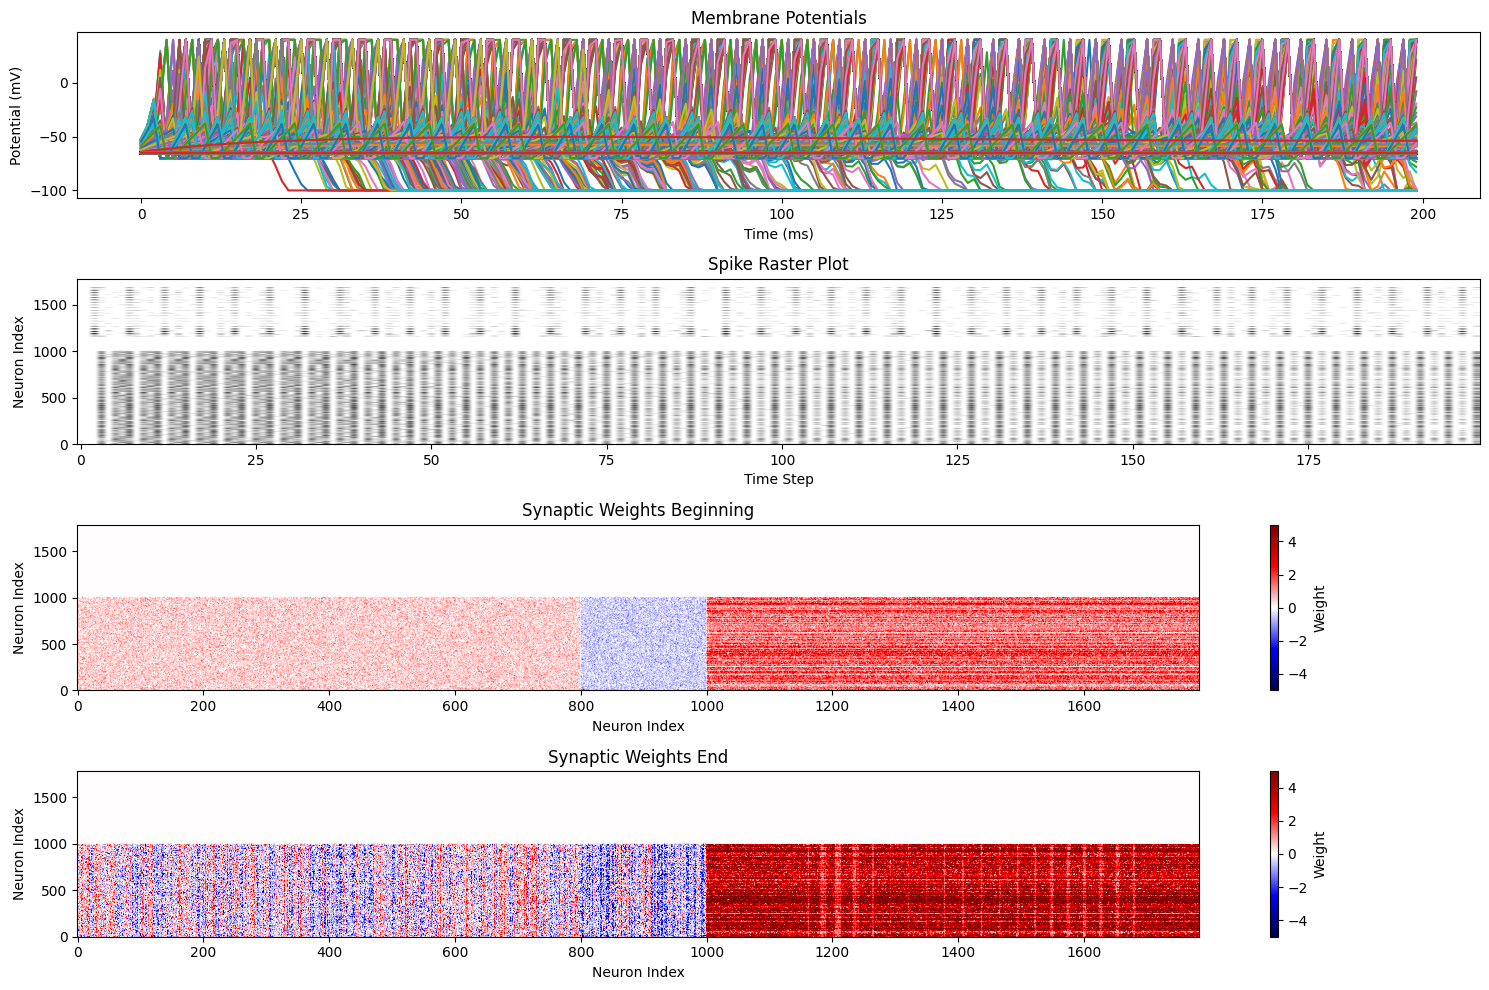

In [15]:
from matplotlib.colors import TwoSlopeNorm

# AdEx neuron dynamics
def adex_dynamics(state, neuron_params, inputs):
    """AdEx neuron dynamics with spiking and refractory period."""
    v, w, refractory_timer = state
    I_ext, I_syn = inputs

    refractory_logic = lambda _: (
        neuron_params["v_reset"], w, refractory_timer - 1, 0.0
    )

    normal_logic = lambda _: (
        v + (-(v - neuron_params["v_rest"])
             + neuron_params["delta_T"] * jnp.exp((v - neuron_params["v_th"]) / neuron_params["delta_T"])
             - w + I_ext + I_syn) / neuron_params["tau_v"],
        w + (neuron_params["a"] * (v - neuron_params["v_rest"]) - w +
             neuron_params["b"] * (v > neuron_params["v_th"])) / neuron_params["tau_w"],
        jnp.where(v > neuron_params["v_th"], neuron_params["refractory"], 0.0),
        (v > neuron_params["v_th"]).astype(float)
    )

    v_new, w_new, refractory_timer_new, spiked = jax.lax.cond(
        refractory_timer > 0, refractory_logic, normal_logic, operand=None
    )
    
    v_new = jnp.minimum(v_new, 40.0)
    v_new = jnp.maximum(v_new,-100.0)

    return jnp.array([v_new, w_new, refractory_timer_new]), spiked

# Exponential synapse dynamics
def synaptic_dynamics(syn_state, syn_params, pre_spike):
    """Exponential synaptic dynamics."""
    return syn_state + (-syn_state / syn_params["tau_syn"] + pre_spike)

# STDP weight updates
def update_weights(weights, pre_spikes, post_spikes, stdp_params, connectivity):
    """Update synaptic weights using the STDP rule with exponential time dependence."""
    
    # Compute the time differences (t = t_post - t_pre) for each pair of neurons
    delta_t = post_spikes[:, None] - pre_spikes[None, :]
    
    # Calculate the weight updates for LTP (pre before post) and LTD (post before pre)
    delta_w_plus = stdp_params["A_plus"] * jnp.exp(-delta_t / stdp_params["tau_plus"]) * (delta_t > 0)  # t > 0: LTP
    delta_w_minus = stdp_params["A_minus"] * jnp.exp(delta_t / stdp_params["tau_minus"]) * (delta_t < 0)  # t < 0: LTD
    
    # Calculate the total weight change
    weight_updates = delta_w_plus - delta_w_minus

    # add here that weights cannot change direction - Dale's principle

    # Ensure that weights initialized to zero stay at zero (for the synapses with no connectivity)
    weights = jnp.where(connectivity == 0, weights, weights + weight_updates)
    
    # Clip the weights to keep them within a defined range, avoiding runaway values
    return jnp.clip(weights, -20.0, 20.0)


# Network update function
def network_update(carry, t, params, I_ext):
    neuron_states, synapse_states, weights, key = carry
    key, subkey = random.split(key)



    pre_spikes = (neuron_states[:, 0] > params["neuron"]["v_th"]).astype(float)

    # Synaptic dynamics: update synapse states
    synapse_states = jax.vmap(synaptic_dynamics, in_axes=(0, None, 0))(
        synapse_states, params["synapse"], pre_spikes
    )
    I_syn = jnp.dot(weights, synapse_states)

    # Neuron dynamics: update states
    neuron_states, spiked = jax.vmap(adex_dynamics, in_axes=(0, None, 0))(
        neuron_states, params["neuron"], jnp.stack([I_ext, I_syn], axis=-1)
    )

    # Update weights
    # Update weights with STDP
    weights = update_weights(weights, pre_spikes, spiked, params["stdp"], connectivity)

    return (neuron_states, synapse_states, weights, key), (neuron_states[:, 0], spiked)

# Simulation
def simulate(T, dt, N, key, params, connectivity, train_images):
    neuron_states = jnp.stack([
        jnp.full((N,), params["neuron"]["v_rest"]),
        jnp.zeros(N),
        jnp.zeros(N)
    ], axis=-1)
    synapse_states = jnp.zeros(N)
    weights = jnp.array(connectivity)
    carry = (neuron_states, synapse_states, weights, key)
    time_steps = jnp.arange(0, T, dt)
    
    
    # External input: stimulate neuron 0 for demonstration
    
    img = train_images[0].flatten()
    
    mean_input = 8.0
    std_input = jnp.sqrt(2.0)  # Standard deviation is sqrt(variance)
    r = jax.random.normal(key, (784,)) * std_input + mean_input

    # Create random input for the last 10 neurons
    I_ext = jnp.zeros(len(neuron_states))
    I_ext = I_ext.at[1000:].set(img)
    
    carry, outputs = scan(lambda carry, t: network_update(carry, t, params, I_ext), carry, time_steps)
    membrane_potentials, spikes = outputs
    return jnp.array(membrane_potentials).T, jnp.array(spikes).T, jnp.array(carry[2]).T, time_steps
    # return jnp.array(membrane_potentials).T, jnp.array(spikes).T, jnp.array(weights).T, time_steps

# Plotting results
def plot_results(time, membrane_potentials, spikes, weights):

    norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
    plt.figure(figsize=(15, 10))
    plt.subplot(4, 1, 1)
    plt.plot(time, membrane_potentials.T[:, :])
    plt.title("Membrane Potentials")
    plt.xlabel("Time (ms)")
    plt.ylabel("Potential (mV)")

    plt.subplot(4, 1, 2)
    plt.imshow(spikes, aspect="auto", cmap="gray_r", origin="lower")
    plt.title("Spike Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Neuron Index")

    plt.subplot(4, 1, 3)
    plt.imshow(connectivity, aspect="auto", cmap="seismic", origin="lower", norm=norm)
    plt.title("Synaptic Weights Beginning")
    plt.xlabel("Neuron Index")
    plt.ylabel("Neuron Index")
    plt.colorbar(label="Weight")
    
    plt.subplot(4, 1, 4)
    plt.imshow(weights[:,:].T, aspect="auto", cmap="seismic", origin="lower", norm=norm)
    plt.title("Synaptic Weights End")
    plt.xlabel("Neuron Index")
    plt.ylabel("Neuron Index")
    plt.colorbar(label="Weight")
    plt.tight_layout()
    plt.show()
    


# Define the connectivity matrix
N = 1784

# convert graph to connectivity matrix
adj_matrix_sparse = nx.adjacency_matrix(G)
adj_matrix_dense = adj_matrix_sparse.toarray()
connectivity = jnp.array(adj_matrix_dense).T

# Simulation parameters
key = random.PRNGKey(42)
T = 200  # Simulation time (ms)
dt = 1.0  # Time step (ms)

# Define parameters
params = {
    "neuron": {
        "v_rest": -65.0,  # Resting membrane potential (mV)
        "v_th": -50.0,    # Threshold potential (mV)
        "delta_T": 2.0,   # Slope factor (mV)
        "tau_v": 20.0,    # Membrane time constant (ms)
        "a": 0.5,        # Subthreshold adaptation (nS)
        "b": 7,         # Spike-triggered adaptation (nA)
        "tau_w": 100.0,   # Adaptation time constant (ms)
        "v_reset": -70.0, # Reset potential after spike (mV)
        "refractory": 2.0 # Refractory period (ms)
    },
    "synapse": {
        "tau_syn": 10.0  # Synaptic time constant (ms)
    },
    "stdp": {
        "A_plus": 1,   # STDP LTP increment
        "A_minus": 0.5, # STDP LTD decrement
        "tau_plus": 10.0, # STDP LTP time constant (ms)
        "tau_minus": 5.0 # STDP LTD time constant (ms)
    }
}


# Run the simulation
membrane_potentials, spikes, weights, time = simulate(T, dt, N, key, params, connectivity, train_images)
plot_results(time, membrane_potentials, spikes, weights)